In [1]:
#if on collab:
from google.colab import drive
drive.mount('/content/drive')

#replace by the parh to ipeo project in the drive
%cd '/content/drive/Othercomputers/MacBook/ipeo_project copy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/MacBook/ipeo_project copy


In [2]:
#!pip install -r requirements.txt
from tqdm import tqdm
import subprocess
from PIL import Image
import numpy as np
import rasterio as rio
import pandas as pd

from utils import *
from unet_whole_model import *
from dataset import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


##### Observe the full images
We load train & test data, rebuild the full images using the merge_raster.py file and save them.

In [3]:
file_path = "glaciers_mapping_downsampled"
data_paths = {}

#build paths for each pipeline
for pipeline in ["train", "test"]:
    for date in [0,1]:
        data_paths[f"{pipeline}_date{date}"] = f"{file_path}/{pipeline}/date{date}"
    data_paths[f"{pipeline}_gt"] = f"{file_path}/{pipeline}/gt"

In [ ]:
#reconstruct full images
for key, path in tqdm(data_paths.items()):
    output_path = f"{file_path}/{key}_merged.tif"
    # Execute the command to merge rasters using subprocess and save them
    command = ["python", "glaciers_mapping_downsampled/merge_rasters.py", "-i", path, "-o", output_path]
    subprocess.run(command)

100%|██████████| 6/6 [06:25<00:00, 64.27s/it]


Then we save the RGB images in png to be able to observe them and (maybe) draw useful conclusions

In [ ]:
for key in tqdm(data_paths.keys()):
    img_path = f"{file_path}/{key}_merged"
    img = rio.open(f"{img_path}.tif").read()
    if '_gt' in key:
        rgb_image = (img).astype(np.uint8).squeeze(0) * 255
        pil_image = Image.fromarray(rgb_image) #blck and white image
    else:
        rgb_image = (img[:3]*255).astype(np.uint8).transpose(1, 2, 0)
        pil_image = Image.fromarray(rgb_image)
    save_path = f"full_rgb_images/{key}.png"
    pil_image.save(save_path)

100%|██████████| 6/6 [00:54<00:00,  9.01s/it]


### Loading all patches

We store the patches in pytorch datasets :
{
'x' : (position_x_of_patch,
'y' : position_y_of_patch),
'patch_path' : path to the image
'augmentation' : kind of augmentation performed to get this image, currently none
}

In [4]:
all_data = {key : load_paths_data(path) for key, path in data_paths.items()}

Loading data: 100%|██████████| 351/351 [00:00<00:00, 289006.81it/s]


In [5]:
train0_dataset = PatchesDataset(all_data['train_date0'], all_data['train_gt'], 'train0')
train1_dataset = PatchesDataset(all_data['train_date1'], all_data['train_gt'], 'train1')
test0_dataset = PatchesDataset(all_data['test_date0'], all_data['test_gt'], 'test0')
test1_dataset = PatchesDataset(all_data['test_date1'], all_data['test_gt'], 'test1')

### Preprocessing

The preprocessing consist in the zero mean & unit variance normalization channel-wise. It is implemented by the dataset before passing the image to the model.

### First Naive Training with no augmentation

Loading groundtruths: 100%|██████████| 1768/1768 [00:49<00:00, 35.93it/s]


From initial model:


100%|██████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch: 0/15 Train_loss: 0.70156, Train_F1: 0.62178, Train_Accuracy: 0.451152179690099, Val_loss: 0.70508, Val_F1: 0.58714, Val_Accuracy: 0.41558


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch: 1/15 Train_loss: 0.25073, Train_F1: 0.90179, Train_Accuracy: 0.914673135824705, Val_loss: 0.28973, Val_F1: 0.86570, Val_Accuracy: 0.87246


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch: 2/15 Train_loss: 0.17275, Train_F1: 0.93524, Train_Accuracy: 0.942253229543517, Val_loss: 0.17535, Val_F1: 0.92863, Val_Accuracy: 0.93932


100%|██████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch: 3/15 Train_loss: 0.15415, Train_F1: 0.94018, Train_Accuracy: 0.946839109866205, Val_loss: 0.15830, Val_F1: 0.93795, Val_Accuracy: 0.94828


100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch: 4/15 Train_loss: 0.14064, Train_F1: 0.94209, Train_Accuracy: 0.948541028294973, Val_loss: 0.15776, Val_F1: 0.93570, Val_Accuracy: 0.94872


100%|██████████| 5/5 [00:01<00:00,  4.48it/s]


Epoch: 5/15 Train_loss: 0.12331, Train_F1: 0.94867, Train_Accuracy: 0.954285723799796, Val_loss: 0.12531, Val_F1: 0.94707, Val_Accuracy: 0.95718


100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch: 6/15 Train_loss: 0.12762, Train_F1: 0.94534, Train_Accuracy: 0.951277173842419, Val_loss: 0.11537, Val_F1: 0.94005, Val_Accuracy: 0.95065


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


Epoch: 7/15 Train_loss: 0.11881, Train_F1: 0.95026, Train_Accuracy: 0.955937043556117, Val_loss: 0.10120, Val_F1: 0.95022, Val_Accuracy: 0.95822


100%|██████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch: 8/15 Train_loss: 0.10194, Train_F1: 0.95710, Train_Accuracy: 0.961891605785824, Val_loss: 0.14399, Val_F1: 0.93235, Val_Accuracy: 0.94199


100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch: 9/15 Train_loss: 0.10239, Train_F1: 0.95708, Train_Accuracy: 0.961611810558570, Val_loss: 0.10197, Val_F1: 0.94794, Val_Accuracy: 0.95746


100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch: 10/15 Train_loss: 0.09828, Train_F1: 0.95733, Train_Accuracy: 0.961766936504595, Val_loss: 0.10668, Val_F1: 0.94884, Val_Accuracy: 0.95651


100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch: 11/15 Train_loss: 0.09353, Train_F1: 0.96047, Train_Accuracy: 0.964615528058466, Val_loss: 0.08169, Val_F1: 0.95734, Val_Accuracy: 0.96448


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch: 12/15 Train_loss: 0.09019, Train_F1: 0.96112, Train_Accuracy: 0.965108641765947, Val_loss: 0.09001, Val_F1: 0.96061, Val_Accuracy: 0.96714


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch: 13/15 Train_loss: 0.09078, Train_F1: 0.96026, Train_Accuracy: 0.964409925266654, Val_loss: 0.14276, Val_F1: 0.92856, Val_Accuracy: 0.93705


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch: 14/15 Train_loss: 0.09324, Train_F1: 0.95892, Train_Accuracy: 0.963145608197667, Val_loss: 0.08919, Val_F1: 0.95892, Val_Accuracy: 0.96604


100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch: 15/15 Train_loss: 0.09313, Train_F1: 0.95837, Train_Accuracy: 0.962764818669952, Val_loss: 0.14231, Val_F1: 0.94036, Val_Accuracy: 0.95226


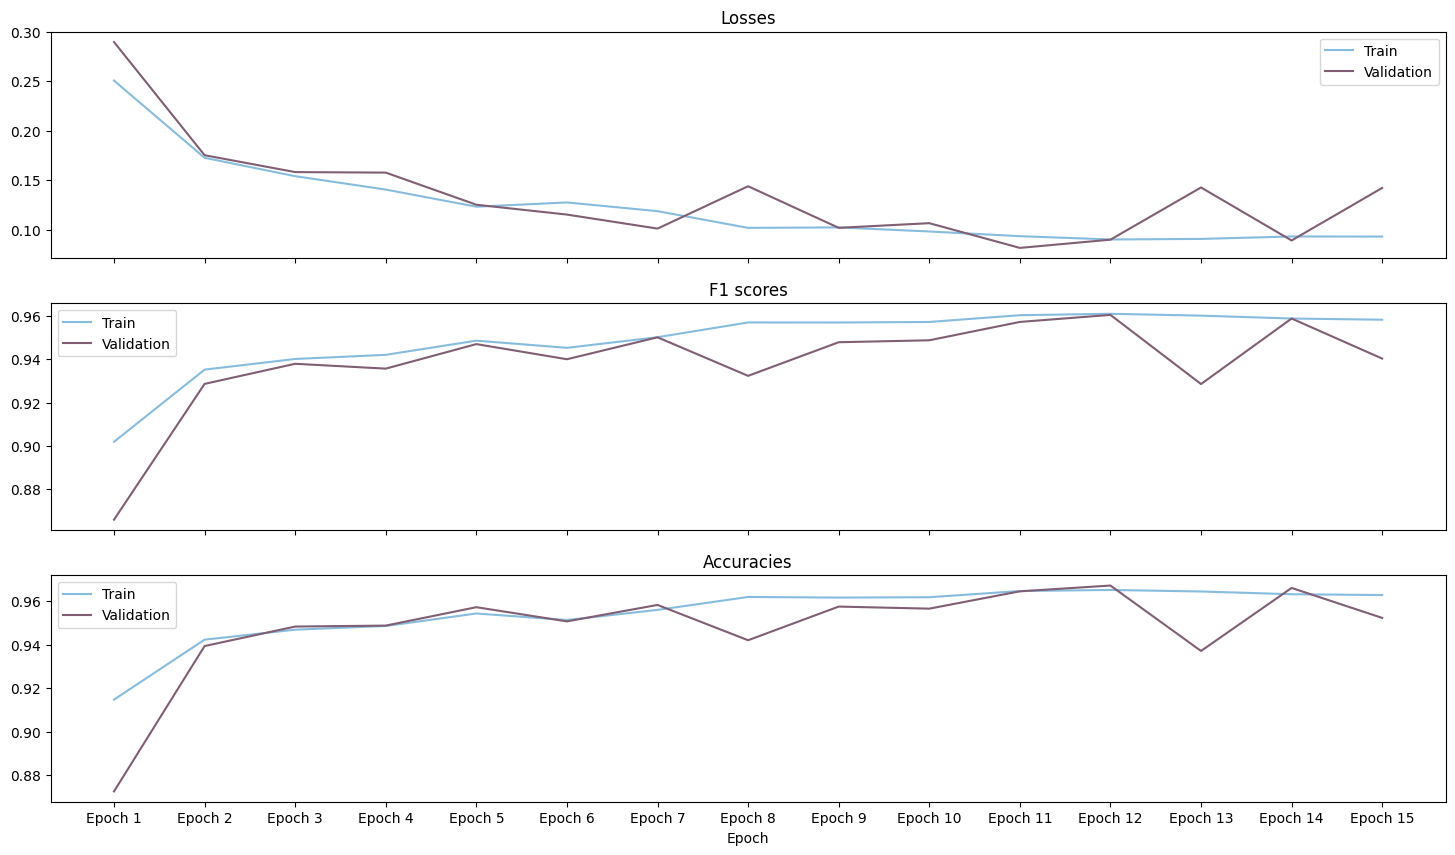

In [10]:
modelname1 = "no_augmentation_model"
lr = 8e-4
n_epochs = 15
no_augmentation_model = Model(modelname1, lr = lr)
no_augmentation_model.train(train0_dataset, num_epochs= n_epochs)
no_augmentation_model.plot_history()

In [11]:
test_records = pd.DataFrame({"model" : [],
                            "trained_on" : [],
                             "best_epoch" : [],
                             "train1" : [],
                             "train0" : [],
                             "train0_augmented" : [],
                             "train1_augmented" : [],
                             "train0&1_augmented" : [],
                             "test0" : [],
                             "test1" : []
                             })

In [12]:
train0_dataset.deload()

test_records = fill_test_record(test_records,
                 modelname1,
                 no_augmentation_model,
                 'train0',
                  [train1_dataset, test0_dataset, test1_dataset])

display(test_records)


100%|██████████| 6/6 [00:01<00:00,  4.11it/s]


,model,trained_on,best_epoch,train1,train0,train0_augmented,train1_augmented,train0&1_augmented,test0,test1
0,no_augmentation_model,train0,12.0,0.867581,0.960607,None,None,None,0.934375,0.870944


### Data Augmentation

In [13]:
train0_dataset_augmented = PatchesDataset(all_data['train_date0'], all_data['train_gt'], 'train0_augmented')
train0_dataset_augmented.augment()

Augmenting dataset: 100%|██████████| 1768/1768 [00:08<00:00, 207.01it/s]


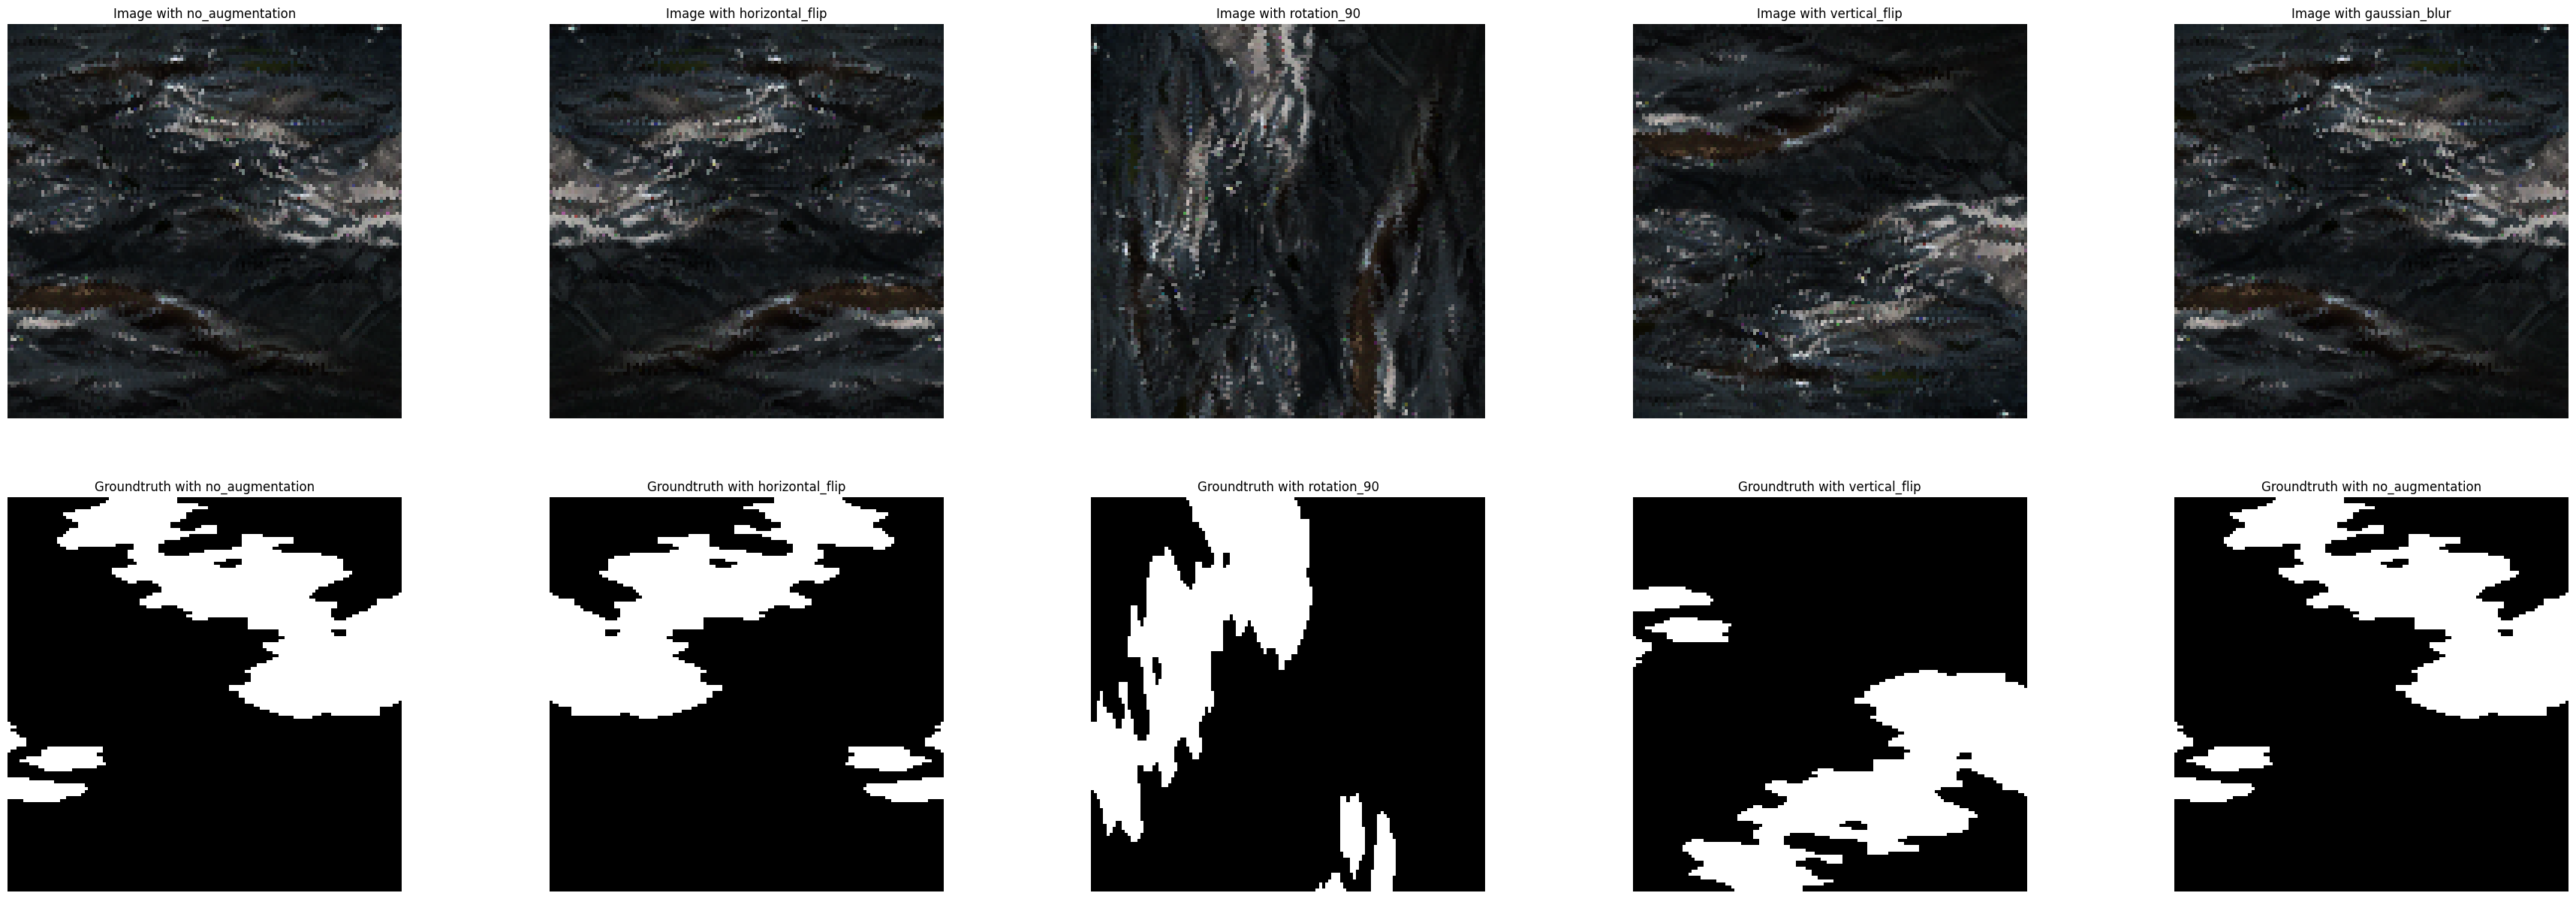

In [14]:
pos_x_ex = 3
pos_y_ex = 9

train0_dataset_augmented.plot_at_pos(pos_x_ex, pos_y_ex)

### Training with augmented data at one date

From initial model:


100%|██████████| 19/19 [00:04<00:00,  3.98it/s]


Epoch: 0/15 Train_loss: 0.69198, Train_F1: 0.61883, Train_Accuracy: 0.448047508264553, Val_loss: 0.69216, Val_F1: 0.61161, Val_Accuracy: 0.44052


100%|██████████| 19/19 [00:05<00:00,  3.78it/s]


Epoch: 1/15 Train_loss: 0.17072, Train_F1: 0.93459, Train_Accuracy: 0.942221754019408, Val_loss: 0.13336, Val_F1: 0.94135, Val_Accuracy: 0.94919


100%|██████████| 19/19 [00:05<00:00,  3.72it/s]


Epoch: 2/15 Train_loss: 0.11530, Train_F1: 0.95095, Train_Accuracy: 0.956693851697596, Val_loss: 0.10178, Val_F1: 0.95443, Val_Accuracy: 0.96082


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Epoch: 3/15 Train_loss: 0.10331, Train_F1: 0.95383, Train_Accuracy: 0.959064705781319, Val_loss: 0.10262, Val_F1: 0.95111, Val_Accuracy: 0.95624


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch: 4/15 Train_loss: 0.08960, Train_F1: 0.95983, Train_Accuracy: 0.964325221797753, Val_loss: 0.10038, Val_F1: 0.95571, Val_Accuracy: 0.96179


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Epoch: 5/15 Train_loss: 0.09178, Train_F1: 0.95901, Train_Accuracy: 0.963614197408804, Val_loss: 0.10086, Val_F1: 0.95754, Val_Accuracy: 0.96209


100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


Epoch: 6/15 Train_loss: 0.08547, Train_F1: 0.96112, Train_Accuracy: 0.965451999701518, Val_loss: 0.18371, Val_F1: 0.90574, Val_Accuracy: 0.91076


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Epoch: 7/15 Train_loss: 0.08194, Train_F1: 0.96250, Train_Accuracy: 0.966625469590023, Val_loss: 0.07907, Val_F1: 0.96305, Val_Accuracy: 0.96775


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch: 8/15 Train_loss: 0.08191, Train_F1: 0.96251, Train_Accuracy: 0.966683076818490, Val_loss: 0.12672, Val_F1: 0.94991, Val_Accuracy: 0.95729


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch: 9/15 Train_loss: 0.07736, Train_F1: 0.96449, Train_Accuracy: 0.968388037888777, Val_loss: 0.07933, Val_F1: 0.96286, Val_Accuracy: 0.96723


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


Epoch: 10/15 Train_loss: 0.07588, Train_F1: 0.96494, Train_Accuracy: 0.968814354833681, Val_loss: 0.07857, Val_F1: 0.96309, Val_Accuracy: 0.96799


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Epoch: 11/15 Train_loss: 0.07491, Train_F1: 0.96522, Train_Accuracy: 0.969054192507228, Val_loss: 0.07757, Val_F1: 0.96263, Val_Accuracy: 0.96760


100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


Epoch: 12/15 Train_loss: 0.07626, Train_F1: 0.96459, Train_Accuracy: 0.968510117222140, Val_loss: 0.08279, Val_F1: 0.96147, Val_Accuracy: 0.96677


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch: 13/15 Train_loss: 0.07354, Train_F1: 0.96587, Train_Accuracy: 0.969612935714879, Val_loss: 0.07903, Val_F1: 0.96213, Val_Accuracy: 0.96734


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


Epoch: 14/15 Train_loss: 0.07384, Train_F1: 0.96551, Train_Accuracy: 0.969298766133632, Val_loss: 0.07316, Val_F1: 0.96475, Val_Accuracy: 0.96910


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Epoch: 15/15 Train_loss: 0.07713, Train_F1: 0.96409, Train_Accuracy: 0.968058162985770, Val_loss: 0.07901, Val_F1: 0.96276, Val_Accuracy: 0.96718


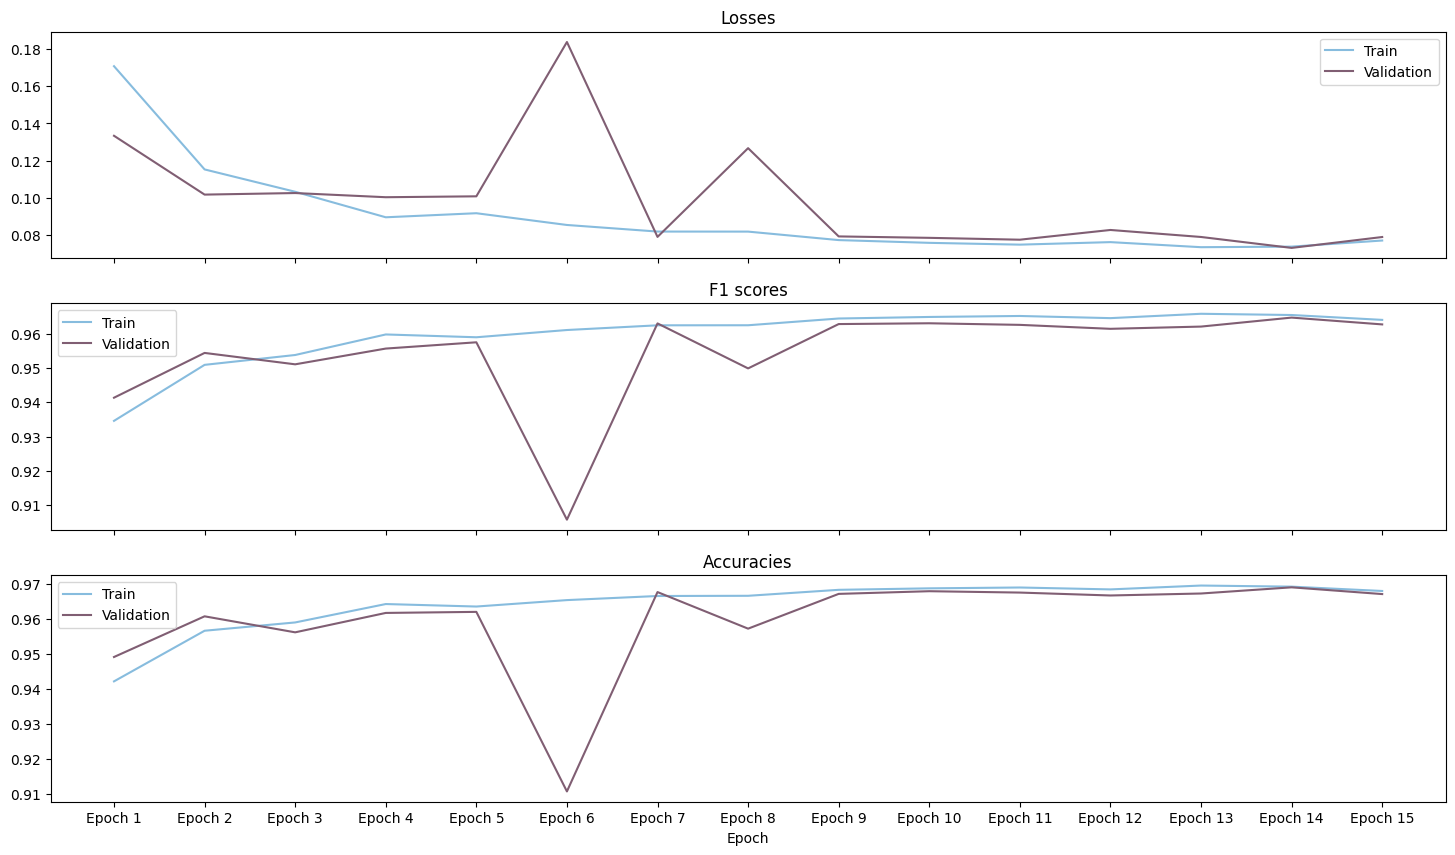

In [15]:
modelname2 = 'augmented_model0'
lr = 8e-4
n_epochs = 15
augmented_model0 = Model(modelname2, lr = lr)
augmented_model0.train(train0_dataset_augmented,num_epochs= n_epochs)
augmented_model0.plot_history()

In [16]:
train0_dataset_augmented.deload()
test_records = fill_test_record(
                test_records,
                modelname2,
                augmented_model0,
                'train0_augmented',
                [train1_dataset, test0_dataset, test1_dataset])

display(test_records)

del train0_dataset_augmented



100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


,model,trained_on,best_epoch,train1,train0,train0_augmented,train1_augmented,train0&1_augmented,test0,test1
0,no_augmentation_model,train0,12.0,0.867581,0.960607,NaN,None,None,0.934375,0.870944
0,augmented_model0,train0_augmented,14.0,0.858540,None,0.964753,None,None,0.938921,0.889138


In [19]:
train1_dataset_augmented = PatchesDataset(all_data['train_date1'], all_data['train_gt'], 'train1_augmented')
train1_dataset_augmented.augment()

Augmenting dataset: 100%|██████████| 1768/1768 [00:08<00:00, 211.71it/s]


From initial model:


100%|██████████| 19/19 [00:04<00:00,  3.97it/s]


Epoch: 0/15 Train_loss: 0.69190, Train_F1: 0.00058, Train_Accuracy: 0.550370413150598, Val_loss: 0.69167, Val_F1: 0.00067, Val_Accuracy: 0.57508


100%|██████████| 19/19 [00:05<00:00,  3.79it/s]


Epoch: 1/15 Train_loss: 0.21317, Train_F1: 0.90732, Train_Accuracy: 0.918952481938440, Val_loss: 0.20506, Val_F1: 0.91146, Val_Accuracy: 0.92919


100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


Epoch: 2/15 Train_loss: 0.16137, Train_F1: 0.92665, Train_Accuracy: 0.934871826714329, Val_loss: 0.17971, Val_F1: 0.91890, Val_Accuracy: 0.92788


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


Epoch: 3/15 Train_loss: 0.14482, Train_F1: 0.93364, Train_Accuracy: 0.940711709521043, Val_loss: 0.17549, Val_F1: 0.91499, Val_Accuracy: 0.92534


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch: 4/15 Train_loss: 0.13725, Train_F1: 0.93704, Train_Accuracy: 0.943908284565481, Val_loss: 0.16681, Val_F1: 0.92280, Val_Accuracy: 0.93127


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


Epoch: 5/15 Train_loss: 0.13076, Train_F1: 0.94000, Train_Accuracy: 0.946368577268067, Val_loss: 0.15666, Val_F1: 0.93024, Val_Accuracy: 0.93957


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Epoch: 6/15 Train_loss: 0.13686, Train_F1: 0.93644, Train_Accuracy: 0.943464484572887, Val_loss: 0.14742, Val_F1: 0.93379, Val_Accuracy: 0.94195


100%|██████████| 19/19 [00:05<00:00,  3.63it/s]


Epoch: 7/15 Train_loss: 0.13241, Train_F1: 0.93909, Train_Accuracy: 0.945784950623634, Val_loss: 0.12820, Val_F1: 0.94270, Val_Accuracy: 0.95057


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Epoch: 8/15 Train_loss: 0.12456, Train_F1: 0.94226, Train_Accuracy: 0.948621670487474, Val_loss: 0.14867, Val_F1: 0.93133, Val_Accuracy: 0.94411


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Epoch: 9/15 Train_loss: 0.12785, Train_F1: 0.94008, Train_Accuracy: 0.946618377500208, Val_loss: 0.26077, Val_F1: 0.92775, Val_Accuracy: 0.94054


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


Epoch: 10/15 Train_loss: 0.12584, Train_F1: 0.94196, Train_Accuracy: 0.948205761689819, Val_loss: 0.11713, Val_F1: 0.94289, Val_Accuracy: 0.95237


100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


Epoch: 11/15 Train_loss: 0.11619, Train_F1: 0.94621, Train_Accuracy: 0.952013890737252, Val_loss: 0.10639, Val_F1: 0.94871, Val_Accuracy: 0.95686


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch: 12/15 Train_loss: 0.11412, Train_F1: 0.94740, Train_Accuracy: 0.953054056010799, Val_loss: 0.10941, Val_F1: 0.94772, Val_Accuracy: 0.95616


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch: 13/15 Train_loss: 0.11691, Train_F1: 0.94606, Train_Accuracy: 0.951815207787504, Val_loss: 0.11031, Val_F1: 0.94560, Val_Accuracy: 0.95419


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Epoch: 14/15 Train_loss: 0.11538, Train_F1: 0.94676, Train_Accuracy: 0.952487462433227, Val_loss: 0.56594, Val_F1: 0.78737, Val_Accuracy: 0.77533


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Epoch: 15/15 Train_loss: 0.11920, Train_F1: 0.94554, Train_Accuracy: 0.951364545747274, Val_loss: 0.28643, Val_F1: 0.85684, Val_Accuracy: 0.86095


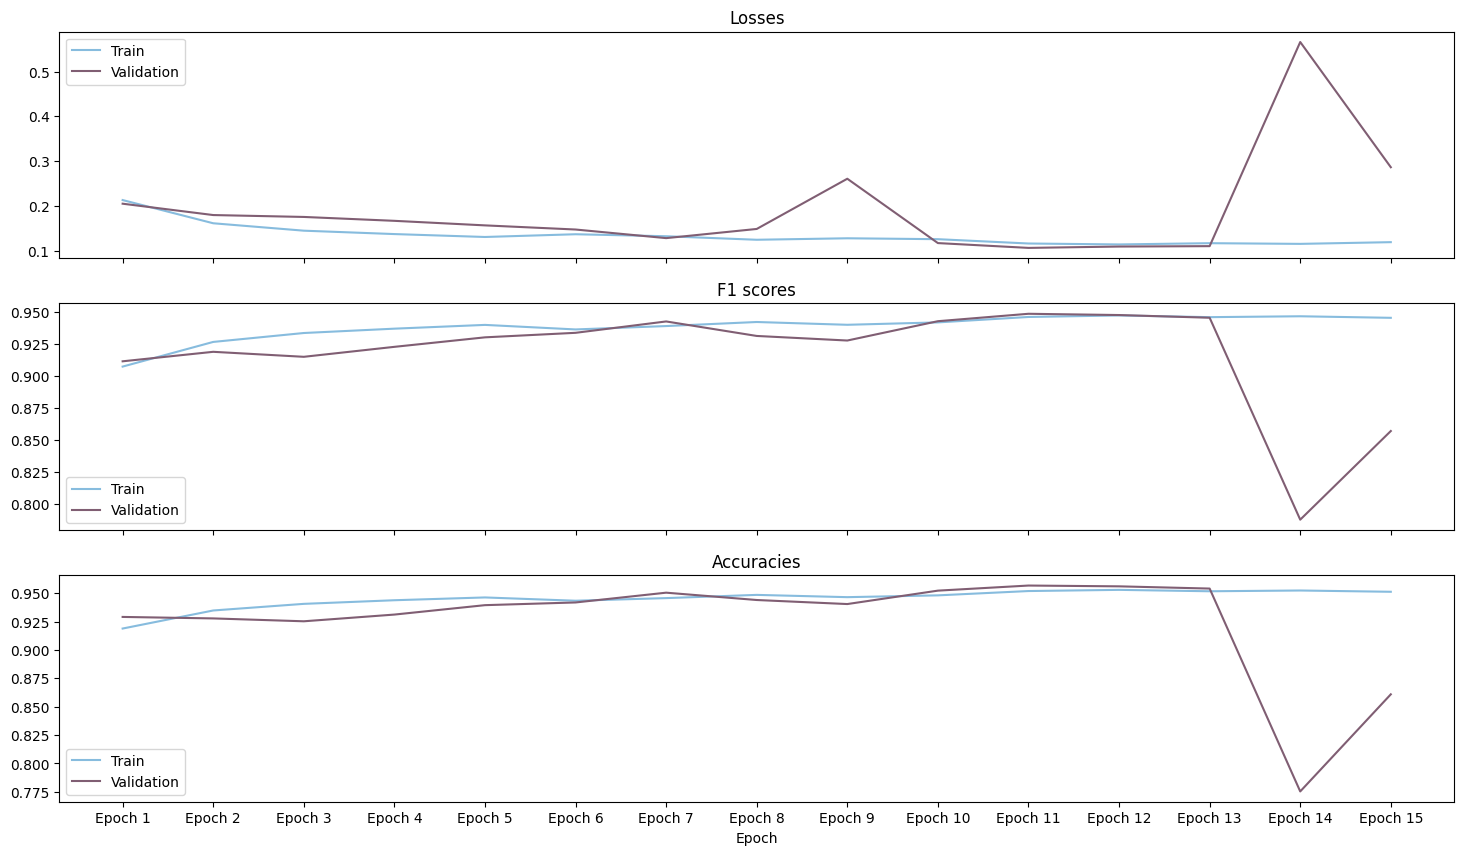

In [20]:
modelname3 = 'augmented_model1'
augmented_model1 = Model(modelname3, lr = lr)
augmented_model1.train(train1_dataset_augmented,num_epochs= n_epochs)
augmented_model1.plot_history()

In [21]:
train1_dataset_augmented.deload()

test_records = fill_test_record(
                test_records,
                modelname3,
                augmented_model1,
                'train1_augmented',
                [train0_dataset, test0_dataset, test1_dataset])

display(test_records)

del train1_dataset_augmented



100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


,model,trained_on,best_epoch,train1,train0,train0_augmented,train1_augmented,train0&1_augmented,test0,test1
0,no_augmentation_model,train0,12.0,0.867581,0.960607,NaN,NaN,None,0.934375,0.870944
0,augmented_model0,train0_augmented,14.0,0.85854,None,0.964753,NaN,None,0.938921,0.889138
0,augmented_model1,train1_augmented,11.0,None,0.892273,None,0.948706,None,0.788659,0.838080


### Training with augmented data at both dates

In [6]:
train0_and_1_dataset_augmented = PatchesDataset(all_data['train_date0'] + all_data['train_date1'],
                                                all_data['train_gt'] + all_data['train_gt'],
                                                "both_dates")
train0_and_1_dataset_augmented.augment()

Augmenting dataset: 100%|██████████| 3536/3536 [00:18<00:00, 188.27it/s]


From initial model:


100%|██████████| 38/38 [00:09<00:00,  3.99it/s]


Epoch: 0/15 Train_loss: 0.68763, Train_F1: 0.00000, Train_Accuracy: 0.554170736578703, Val_loss: 0.68730, Val_F1: 0.00000, Val_Accuracy: 0.55525


100%|██████████| 38/38 [00:10<00:00,  3.76it/s]


Epoch: 1/15 Train_loss: 0.19428, Train_F1: 0.91643, Train_Accuracy: 0.926711207769569, Val_loss: 0.21711, Val_F1: 0.90691, Val_Accuracy: 0.91130


100%|██████████| 38/38 [00:10<00:00,  3.66it/s]


Epoch: 2/15 Train_loss: 0.14357, Train_F1: 0.93524, Train_Accuracy: 0.942943606527035, Val_loss: 0.13059, Val_F1: 0.94009, Val_Accuracy: 0.94775


100%|██████████| 38/38 [00:10<00:00,  3.67it/s]


Epoch: 3/15 Train_loss: 0.13090, Train_F1: 0.94012, Train_Accuracy: 0.947189735656598, Val_loss: 0.12561, Val_F1: 0.94040, Val_Accuracy: 0.94767


100%|██████████| 38/38 [00:10<00:00,  3.66it/s]


Epoch: 4/15 Train_loss: 0.11963, Train_F1: 0.94479, Train_Accuracy: 0.951276444871067, Val_loss: 0.10679, Val_F1: 0.95009, Val_Accuracy: 0.95629


100%|██████████| 38/38 [00:10<00:00,  3.66it/s]


Epoch: 5/15 Train_loss: 0.11214, Train_F1: 0.94803, Train_Accuracy: 0.954106566490209, Val_loss: 0.12748, Val_F1: 0.94129, Val_Accuracy: 0.94926


100%|██████████| 38/38 [00:10<00:00,  3.65it/s]


Epoch: 6/15 Train_loss: 0.11039, Train_F1: 0.94897, Train_Accuracy: 0.954934325648935, Val_loss: 0.10884, Val_F1: 0.94935, Val_Accuracy: 0.95609


100%|██████████| 38/38 [00:10<00:00,  3.66it/s]


Epoch: 7/15 Train_loss: 0.10595, Train_F1: 0.95093, Train_Accuracy: 0.956646740687493, Val_loss: 0.15912, Val_F1: 0.92970, Val_Accuracy: 0.94082


100%|██████████| 38/38 [00:10<00:00,  3.65it/s]


Epoch: 8/15 Train_loss: 0.10757, Train_F1: 0.95037, Train_Accuracy: 0.956137433662417, Val_loss: 0.09554, Val_F1: 0.95592, Val_Accuracy: 0.96130


100%|██████████| 38/38 [00:10<00:00,  3.65it/s]


Epoch: 9/15 Train_loss: 0.09792, Train_F1: 0.95451, Train_Accuracy: 0.959778765207802, Val_loss: 0.09222, Val_F1: 0.95568, Val_Accuracy: 0.96143


100%|██████████| 38/38 [00:10<00:00,  3.62it/s]


Epoch: 10/15 Train_loss: 0.10142, Train_F1: 0.95295, Train_Accuracy: 0.958422886725674, Val_loss: 0.17524, Val_F1: 0.92434, Val_Accuracy: 0.93008


100%|██████████| 38/38 [00:10<00:00,  3.66it/s]


Epoch: 11/15 Train_loss: 0.09846, Train_F1: 0.95422, Train_Accuracy: 0.959504375236585, Val_loss: 0.10475, Val_F1: 0.95395, Val_Accuracy: 0.95981


100%|██████████| 38/38 [00:10<00:00,  3.64it/s]


Epoch: 12/15 Train_loss: 0.09308, Train_F1: 0.95641, Train_Accuracy: 0.961443105875561, Val_loss: 0.12800, Val_F1: 0.94516, Val_Accuracy: 0.95128


100%|██████████| 38/38 [00:10<00:00,  3.65it/s]


Epoch: 13/15 Train_loss: 0.09248, Train_F1: 0.95681, Train_Accuracy: 0.961803889061519, Val_loss: 0.12585, Val_F1: 0.94150, Val_Accuracy: 0.95002


100%|██████████| 38/38 [00:10<00:00,  3.64it/s]


Epoch: 14/15 Train_loss: 0.09380, Train_F1: 0.95621, Train_Accuracy: 0.961269521512506, Val_loss: 0.08792, Val_F1: 0.95772, Val_Accuracy: 0.96313


100%|██████████| 38/38 [00:10<00:00,  3.64it/s]


Epoch: 15/15 Train_loss: 0.09013, Train_F1: 0.95760, Train_Accuracy: 0.962487578383224, Val_loss: 0.08674, Val_F1: 0.95995, Val_Accuracy: 0.96406


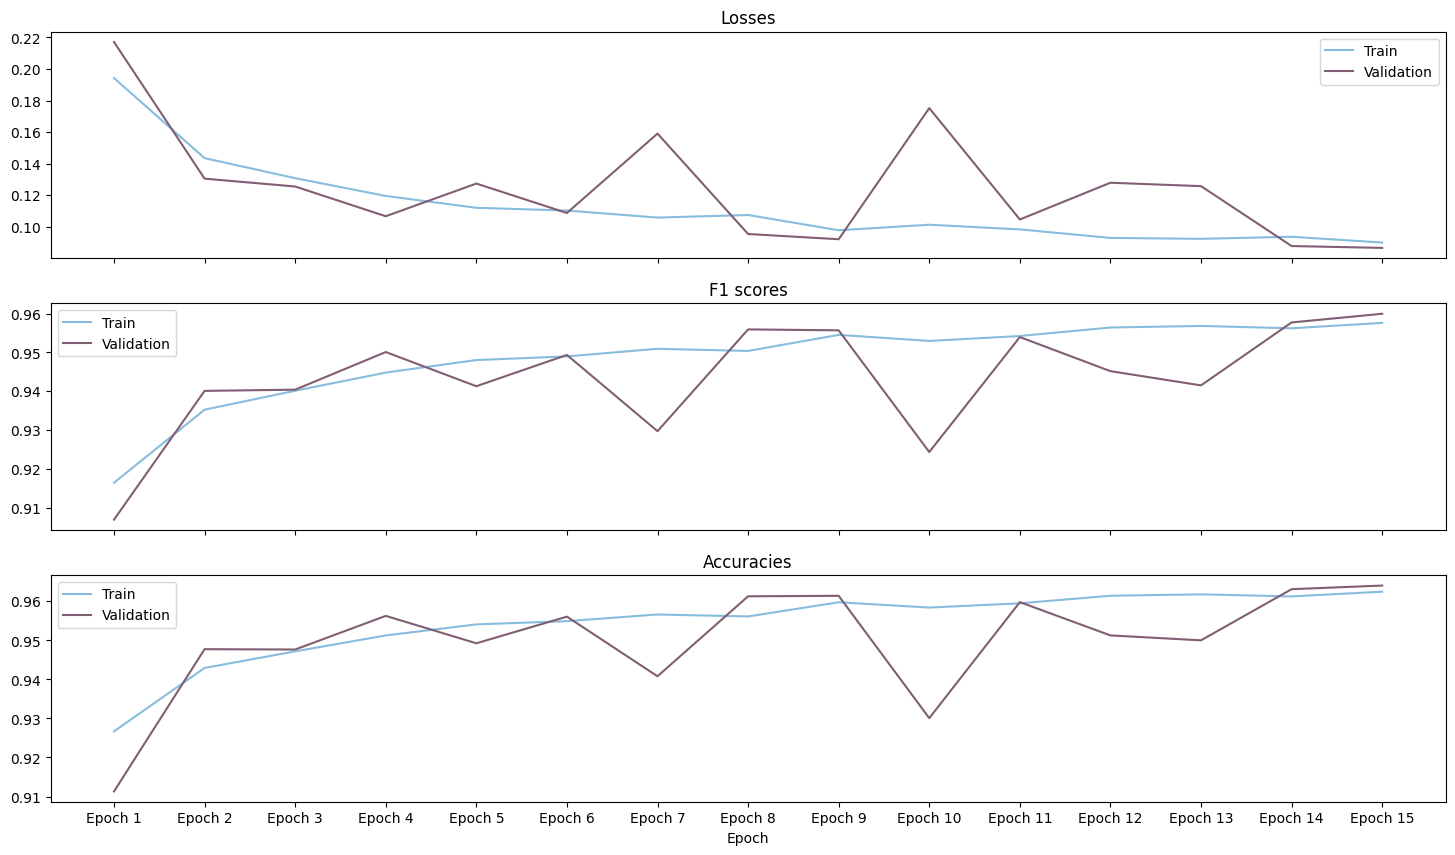

In [7]:
modelname4 = 'augmented_model_both'
lr = 8e-4
n_epochs = 15
model_both = Model(modelname4, lr = lr)
model_both.train(train0_and_1_dataset_augmented,num_epochs= n_epochs)
model_both.plot_history()

In [10]:
train0_and_1_dataset_augmented.deload()
test_records = fill_test_record(
                test_records,
                modelname4,
                model_both,
                'both_dates_augmented',
                [test0_dataset, test1_dataset])

display(test_records)

del train0_and_1_dataset_augmented

100%|██████████| 6/6 [00:01<00:00,  4.12it/s]


,model,trained_on,best_epoch,train1,train0,train0_augmented,train1_augmented,train0&1_augmented,test0,test1,both_dates_augmented
0,no_augmentation_model,train0,12,0.867581,0.960607,NaN,NaN,NaN,0.934375,0.870944,NaN
1,augmented_model0,train0_augmented,14,0.85854,NaN,0.964753,NaN,NaN,0.938921,0.889138,NaN
2,augmented_model1,train1_augmented,11,NaN,0.892273,NaN,0.948706,NaN,0.788659,0.838080,NaN
0,augmented_model_both,both_dates_augmented,15,None,None,None,None,None,0.938606,0.868415,0.959948


Best model: augmented_model0 at epoch 15 on test0